In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import and asses dataset
# Dataset description can be found at: https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset?select=covid.csv
df = pd.read_csv("../data/mexico_government_covid19_patient/covid.csv")
print(df.shape)
df.head()

(566602, 23)


,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


In [3]:
# Change the data died column to indicate if patient death
# If there is a valid date then patient death and represent as 1 otherwise represent as 2
df['date_died'] = df['date_died'].replace(to_replace="9999-99-99", value=2)
df['date_died'] = df['date_died'].mask(df['date_died'].ne(2), 1)
df = df.rename(columns={'date_died':'lethal'})
df.head()

,id,sex,patient_type,entry_date,date_symptoms,lethal,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,2,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,2,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,2,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,2,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,1,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


In [4]:
# With date_symptoms and entry_date we can calculate time between disease contraction and medical attention
# This would be a more relevant feature to use rather than just the dates
df['days_to_medical_help'] = (pd.to_datetime(df['entry_date'], dayfirst=True) - pd.to_datetime(df['date_symptoms'], dayfirst=True)).dt.days
df = df.drop(columns=['entry_date', 'date_symptoms'])
df.head()

,id,sex,patient_type,lethal,intubed,pneumonia,age,pregnancy,diabetes,copd,...,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,days_to_medical_help
0,16169f,2,1,2,97,2,27,97,2,2,...,2,2,2,2,2,2,2,1,97,2
1,1009bf,2,1,2,97,2,24,97,2,2,...,2,2,2,2,2,2,99,1,97,2
2,167386,1,2,2,2,2,54,2,2,2,...,2,2,2,1,2,2,99,1,2,5
3,0b5948,2,2,2,2,1,30,97,2,2,...,2,2,2,2,2,2,99,1,2,7
4,0d01b5,1,2,1,2,2,60,2,1,2,...,1,2,1,2,2,2,99,1,2,0


In [5]:
# Drop Patient ID from the dataset since it won't help in predictions
columns_to_drop = ['id']
df = df.drop(columns=columns_to_drop)

In [6]:
# Since most categorical features are currently int64 change them to categorical
# We also want to normalize all non categorical features
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
categorical_columns = ['sex', 'patient_type',
       'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu', 'lethal']
# The dataset indicates that missing values are 97, 98, 99 so we replace them with -1 for uniformity
scalers = {}
for column in df.columns:
    if column in categorical_columns:
        # Change no encoding from 2 to 0
        df[column] = df[column].replace(to_replace=2, value=0)
        # Replace all missing values with -1
        df[column] = df[column].replace(to_replace=[97, 98, 99], value=-1).astype('category')
    else:
        pass
        

In [7]:
# Now we can only use observations in which the individual tested postive for COVID 19
covid_cases = df[df['covid_res'] == 1]
covid_cases.shape

(220657, 21)

In [8]:
# Variables to store the outcomes and features
# We could try combining icu and death
# However we do not want to include either in the prediction for the other due to expected high dependency
features = ['sex', 'patient_type', 'age', 'days_to_medical_help',
       'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco']
"""features = ['sex', 'age', 'days_to_medical_help', 'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco']"""
outcomes = ['icu', 'death']

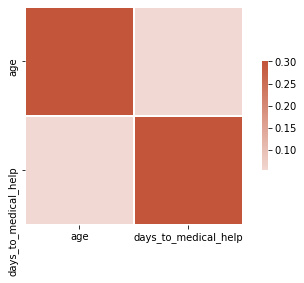

In [9]:
# Correlation Matrix for non-categorical variables
# Source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = covid_cases.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 4))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

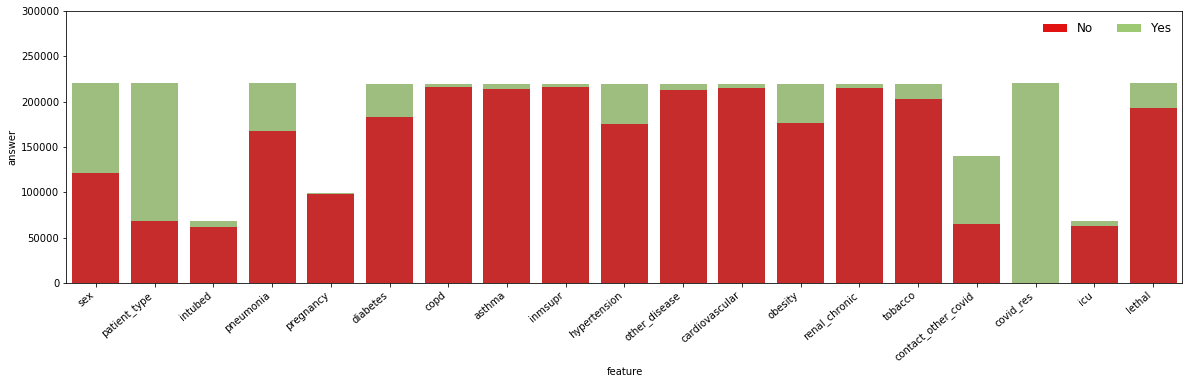

In [10]:
# For our categorical variables we would want to view the distribution of 'yes' and 'no' in each one of them
counts = []
for column in categorical_columns:
    counts.append({'feature': column, 'answer': covid_cases[covid_cases[column] == 0].shape[0], 'total': covid_cases[covid_cases[column] == 1].shape[0] + covid_cases[covid_cases[column] == 0].shape[0]})
counts = pd.DataFrame(counts)
f, ax = plt.subplots(figsize=(20, 5))
ax.set_ylim(0, 300000)
sns.barplot(x = counts.feature, y = counts.total, color = "#9dc974")
no_plot = sns.barplot(x = counts.feature, y = counts.answer, color = "#e01212")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
topbar = plt.Rectangle((0,0),1,1,fc="#9dc974", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#e01212',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['No', 'Yes'], loc=1, ncol = 2, prop={'size':12})
l.draw_frame(False)

-1    152447
 0     62388
 1      5822
Name: icu, dtype: int64

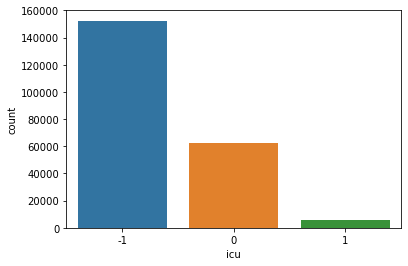

In [11]:
# Before we train we want to check the distribution of icu in the train set to ensure proper training
#-1 means ICU is unknown
sns.countplot(x='icu', data=covid_cases)
covid_cases['icu'].value_counts()

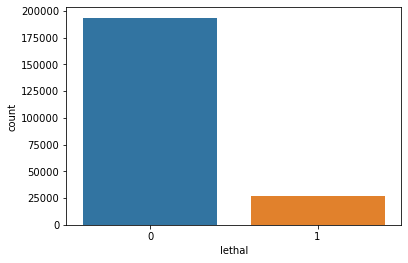

In [12]:
# Before we train we want to check the distribution of icu in the train set to ensure proper training
sns.countplot(x='lethal', data=covid_cases)

from the data gathered, we can see the number of males with Covid is higher than females

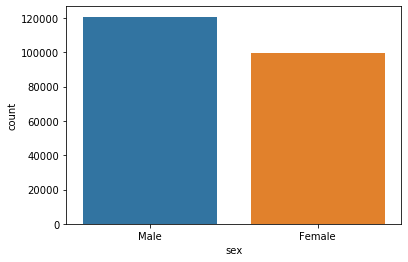

In [13]:
copy = covid_cases.copy()
copy['sex'].replace({0:"Male", 1:"Female"}, inplace=True)
sns.countplot(x='sex', data=copy)

Mean of ages is 45 with Standard deviation of 16. This implies most of the cases are between age (30-60) 

Mean:  45.68820839583607
std:  16.314227340301734


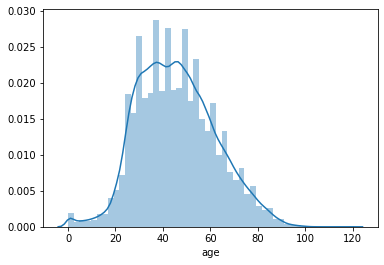

In [14]:
print("Mean: ",covid_cases["age"].mean())
print("std: ",covid_cases["age"].std())
sns.distplot(covid_cases["age"])

Text(0.5, 1, 'Reported intubations \n \n  Ratio=9')

<Figure size 720x576 with 0 Axes>

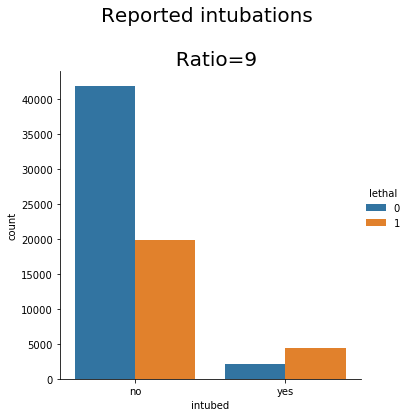

In [15]:
copy = covid_cases.copy()
i = copy[copy["intubed"] == -1].index
copy.drop(i, inplace=True)
copy["intubed"] = copy['intubed'].replace(to_replace=[-1, 1], value="yes")
copy["intubed"] = copy['intubed'].replace(to_replace=[0], value="no")
plt.figure(figsize=(10,8))
ax=sns.catplot('intubed',data=copy,kind='count',hue='lethal')

plt.title('Reported intubations \n \n  Ratio={0:.0f}'.format(copy['intubed'].value_counts()[0]/copy['intubed'].value_counts()[1])
           ,size=20)

1) for every one single reported intubation, there were 9 other patients who weren't intubated.
2) if patient not intubed, then there is big chance that his case is not lethal.
3) 


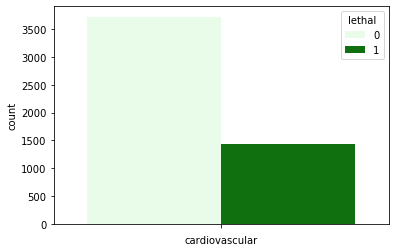

In [47]:
copy = covid_cases.copy()
cols = ['cardiovascular']
for col in cols:
    i = copy[copy[col] != 1].index
    copy.drop(i, inplace=True)
    copy[col] = copy[col].replace(to_replace=[-1, 1,0], value="")
    ax=sns.countplot(col,data=copy,hue='lethal', color='g')
    plt.show()


In [46]:
covid_cases['cardiovascular'].value_counts()

 0    214671
 1      5162
-1       824
Name: cardiovascular, dtype: int64

In [49]:
covid_cases['pneumonia'].value_counts()

 0    167623
 1     53031
-1         3
Name: pneumonia, dtype: int64